<a href="https://colab.research.google.com/github/trishaa4144/cmsc320-final/blob/rat_clean/CMSC320_Checkpt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Initial Data Cleaning

We will start by cleaning our dataset to remove null values, and narrow our dataset down to certain columns.

First, we import our dataset.

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("Rat_Sightings_20240917.csv", low_memory=False)

We filter out unnecessary/sparse columns like "Taxi Pick Up Location", "Bridge Highway Name", etc. This way, we cut the number of columns from 38 to 7 columns.

We are deciding to look at the following important columns: Created Date, Location Type, Incident Zip, Community Board, Borough, Latitude, Longitude.


In [87]:
# Keep only the necessary columns
df = df[['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude']]

Next, we remove Boroughs that are "Unspecified" from the dataframe.

In [88]:
# Drop rows with unspecified boroughs
df = df[df['Borough'] != 'Unspecified']
df.reset_index(drop=True, inplace=True)

Next, drop NA values and duplicates from the dataset.

In [89]:
df.dropna(subset=['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude'], inplace=True)
df.drop_duplicates(inplace=True)

Finally, we will map Location Types to non-duplicate category classifications.

In [90]:
# Get unique values in 'Location Type'
unique_location_types = df['Location Type'].unique()

# Define mapping for residential categories
residential_mapping = {
    'Single Room Occupancy (SRO)': 'Single',
    '1-2 Family Dwelling': '1-2 Family Apartment',
    '1-2 FamilyDwelling': '1-2 Family Apartment',
    '3+ Family Apt. Building': '3+ Family',
    '3+ Family Apartment Building': '3+ Family',
    '3+ Family Apt.': '3+ Family',
    '3+Family Apt.': '3+ Family',
    '3+ Family Apt': '3+ Family',
    '1-3 Family Dwelling': '1-3 Family Dwelling',
    '1-3 Family Mixed Use Building': '1-3 Family Mixed',
    '1-2 Family Mixed Use Building': '1-2 Family Mixed',
    '3+ Family Mixed Use Building': '3+ Family Mixed',
    'Private House': 'Private House',
    'Apartment': 'Apartment',
    'Residential Property': 'Residential Property'
}

# Apply mapping to the 'Location Type' column for residential data
df['Location Type'] = df['Location Type'].replace(residential_mapping)

Now that we have done the initial cleaning of our dataset, lets proceed forward and visualize how rat sightings compare across location, time, and income level.

First, let's visualize how rat sightings compare across Zip Codes

# Part 2: General EDA & Characteristics of Data


Next, we will continue cleaning our dataset while getting key insights on our data results.


Let's start by observing the relationship between sightings in residential and non-residential areas. By this visualization, we can see that the proportion of residential rat sightings is much higher than non-residential sightings. This provides us with insight into the makeup of our dataset.

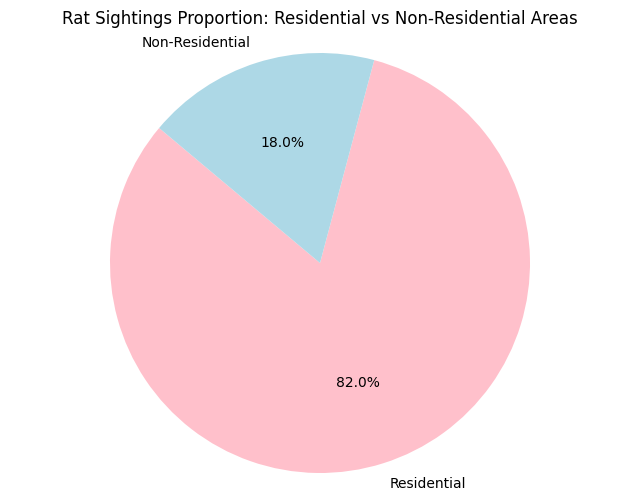

In [91]:
# Create the residential and non-residential DataFrames
residential_df = df[df['Location Type'].isin(residential_mapping.values())]
nonresidential_df = df[~df['Location Type'].isin(residential_mapping.values())]
nonresidential_df = nonresidential_df[~nonresidential_df['Location Type'].isin(['Other', 'Other (Explain Below)'])]

# Basic Data Exploration - residential vs nonresidential pie chart
residential_count = residential_df.shape[0]
nonresidential_count = nonresidential_df.shape[0]

# Data for the pie chart
labels = ['Residential', 'Non-Residential']
sizes = [residential_count, nonresidential_count]
colors = ['pink', 'lightblue']

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Rat Sightings Proportion: Residential vs Non-Residential Areas')
# Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.axis('equal')
plt.show()

In [92]:
# Rough overview of features we want to consider (main characteristics of dataset)

# All boroughs and number of sightings in each
boroughs = df.groupby(['Borough']).groups.keys()
print("********** Boroughs **********")
print(list(boroughs))
mode = df.groupby(['Borough']).count()['Created Date']
print(mode)

# All location types and number of sightings in each
location_type = df.groupby(['Location Type']).groups.keys()
print("\n********** Location Type **********")
print(list(location_type))
mode = df.groupby(['Location Type']).count()['Created Date']
print(mode)

# All zip codes and number of sightings in each (in descending order)
zip_codes = df.groupby(['Incident Zip']).groups.keys()
print("\n********** Incident Zip Code **********")
print(list(zip_codes))


# print top 10 counts per zip codes
zip_code_dict = {}
for key in zip_codes:
  zip_code_dict[key] = len(df[df['Incident Zip'] == key])
print("\n(Incident Zip Code , Count) in descending order:")
zip_code_dict = sorted(zip_code_dict.items(), key=lambda item: item[1], reverse=True)
print(zip_code_dict)

# Rows, columns
print("\n(Rows, columns):")
print(df.shape)

********** Boroughs **********
['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
Borough
BRONX            44464
BROOKLYN         91100
MANHATTAN        64352
QUEENS           38123
STATEN ISLAND     9684
Name: Created Date, dtype: int64

********** Location Type **********
['1-2 Family Apartment', '1-2 Family Mixed', '1-3 Family Dwelling', '1-3 Family Mixed', '3+ Family', '3+ Family Mixed', 'Abandoned Building', 'Apartment', 'Beach', 'Building (Non-Residential)', 'Cafeteria - Public School', 'Catch Basin/Sewer', 'Catering Service', 'Commercial Building', 'Commercial Property', 'Construction Site', 'Day Care/Nursery', 'Government Building', 'Grocery Store', 'Ground', 'Hospital', 'Office Building', 'Other', 'Other (Explain Below)', 'Parking Lot/Garage', 'Private House', 'Public Garden', 'Public Stairs', 'Residence', 'Residential Building', 'Residential Property', 'Restaurant', 'Restaurant/Bar/Deli/Bakery', 'Retail Store', 'School', 'School/Pre-School', 'Single', 'Store', 'Str

Next, let's take a look at the geographic density of rat sightings using our Latitude and Longitude data along with frequencies. It can be seen from the map that there are high concentrations of rat sightings located within Manhattan and Brooklyn in particular.

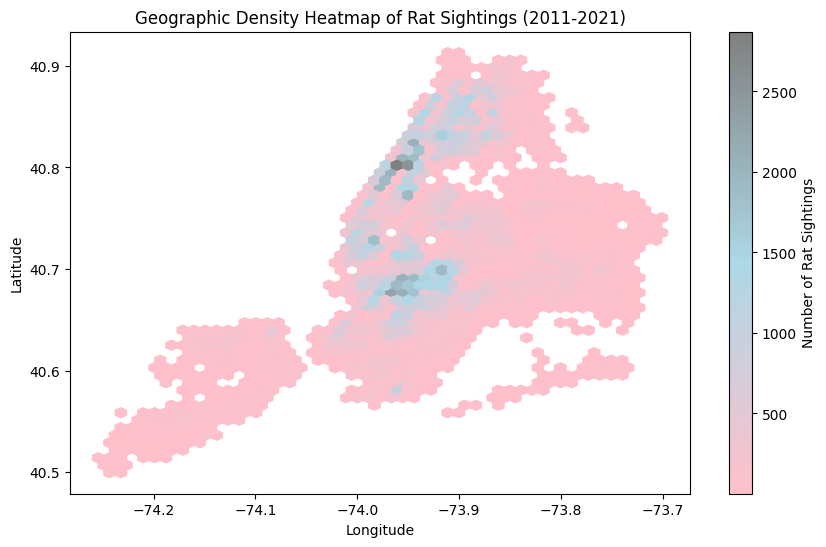

In [93]:
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["pink", "lightblue", "grey"])
plt.figure(figsize=(10, 6))
plt.hexbin(df['Longitude'], df['Latitude'], gridsize=50, cmap=cmap, mincnt=1)
plt.colorbar(label='Number of Rat Sightings')
plt.title('Geographic Density Heatmap of Rat Sightings (2011-2021)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Part 3: Rat Sightings over Time & Seasons

In this section, we explore the patterns of rat sightings over time  by extracting relevant date information from our dataset and visualizing these trends. We will focus on how rat sightings vary across different months and perform a statistical comparison between seasons—specifically, winter and summer.


Extract the month, week, and day from the dates in the dataset.

In [94]:
# Convert 'Created Date' to datetime format
df['Created Date'] = pd.to_datetime(df['Created Date'])

# Extract month, week, and day information
df['Month'] = df['Created Date'].dt.month
df['Week'] = df['Created Date'].dt.isocalendar().week
df['Day'] = df['Created Date'].dt.day

# Check the updated dataframe
print(df[['Created Date', 'Month', 'Week', 'Day']].head())

         Created Date  Month  Week  Day
0 2024-05-31 00:10:00      5    22   31
1 2024-06-01 15:01:00      6    22    1
2 2024-06-06 10:08:00      6    23    6
3 2024-06-25 11:34:00      6    26   25
4 2024-06-27 10:48:00      6    26   27


Visualize Rat sightings across Months

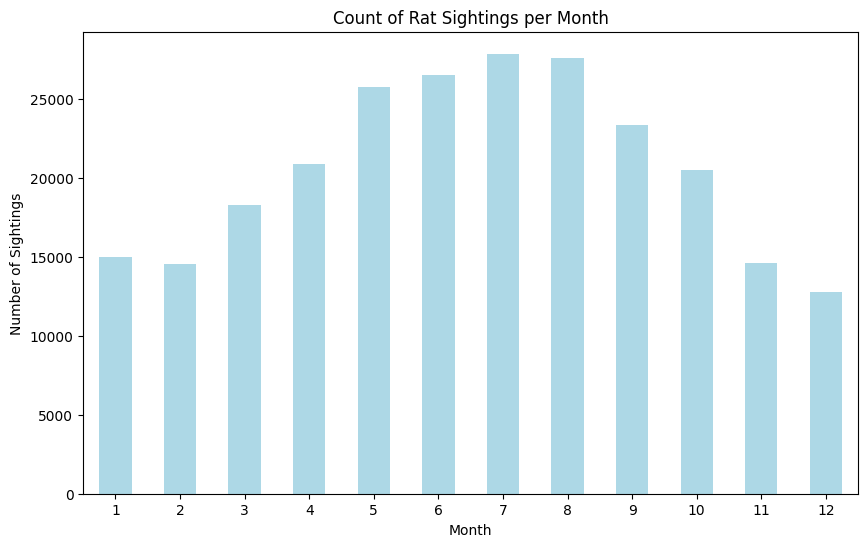

In [95]:
# Count rat sightings per month
rat_sightings_by_month = df['Month'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 6))
rat_sightings_by_month.plot(kind='bar', color='lightblue')
plt.title('Count of Rat Sightings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=0)
plt.show()

## **TEST 1:** T-test on Summer vs Winter Rat Sightings


H0: There is no significant difference in rat sightings between winter months and summer months.

H1: There is a significant difference in rat sightings between winter months and summer months.

In [96]:
# Example: Compare rat sightings between Winter (Dec-Feb) and Summer (Jun-Aug)
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

# Get sightings for winter and summer
winter_sightings = df[df['Month'].isin(winter_months)]['Month'].count()
summer_sightings = df[df['Month'].isin(summer_months)]['Month'].count()

# Filter the data for winter and summer months
winter_data = df[df['Month'].isin([12, 1, 2])]
summer_data = df[df['Month'].isin([6, 7, 8])]


In [97]:
# Check the length of data for both groups
print("Winter sightings count:", len(winter_data))
print("Summer sightings count:", len(summer_data))

Winter sightings count: 42325
Summer sightings count: 82017


In [98]:
# Check for NaN values in these groups
print("NaN in winter data:", winter_data.isna().sum())
print("NaN in summer data:", summer_data.isna().sum())

# Drop rows with missing values in 'Incident Zip', 'Latitude', or 'Longitude'
winter_data_clean = winter_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])
summer_data_clean = summer_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])

# Check cleaned data
print("Cleaned winter data count:", len(winter_data_clean))
print("Cleaned summer data count:", len(summer_data_clean))

NaN in winter data: Created Date       0
Location Type      0
Incident Zip       0
Community Board    0
Borough            0
Latitude           0
Longitude          0
Month              0
Week               0
Day                0
dtype: int64
NaN in summer data: Created Date       0
Location Type      0
Incident Zip       0
Community Board    0
Borough            0
Latitude           0
Longitude          0
Month              0
Week               0
Day                0
dtype: int64
Cleaned winter data count: 42325
Cleaned summer data count: 82017


T test: T-test is only valid if the sample size is normally distributed and independent. By the Central Limit theorem, since the sizes of both datasets are over 30, a normal distribution can be assumed.

In [99]:
# Count the number of sightings per day in both seasons
winter_sightings_per_day = winter_data_clean['Created Date'].dt.date.value_counts()
summer_sightings_per_day = summer_data_clean['Created Date'].dt.date.value_counts()

# Perform the t-test comparing the number of sightings per day in winter vs summer
t_stat, p_value = stats.ttest_ind(winter_sightings_per_day, summer_sightings_per_day, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -32.34263324473203, P-value: 1.700947373903577e-191


The T-test results in a p-value of approximately 1.70e-191. Thus, we reject our null hypothesis of no significant difference between Summer and Winter months. This extremely low p-value indicates a highly significant difference in the number of rat sightings between winter and summer. This supports the conclusion that rat sightings are substantially more prevalent during the summer months compared to winter. The results highlight the importance of seasonal factors in understanding rat populations and could inform pest management strategies.


# Part 4: Rat Sightings and Location

## **Test 2**: ANOVA Test on Rat Sightings across Boroughs

The ANOVA test is used to assess if there are significant differences in average rat sightings per zip code across different boroughs. Its purpose is to compare the means of multiple groups.

H0: There are no significant differences in mean rat sightings across boroughs

H1: There are significant differences in mean rat sightings across boroughs

In [100]:
from scipy import stats

sightings_per_zip = df.groupby(['Borough', 'Incident Zip']).size().reset_index(name='Sightings')

# group by Borough to prepare for ANOVA
sightings_by_borough = sightings_per_zip.groupby('Borough')['Sightings'].apply(list).reset_index()
print(sightings_by_borough)

# Extracting sightings lists for each borough
borough_groups = sightings_by_borough['Sightings'].tolist()

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*borough_groups)

print(f'P-value: {p_value}')

         Borough                                          Sightings
0          BRONX  [1774, 2497, 2578, 1279, 1835, 3619, 3070, 318...
1       BROOKLYN  [1981, 2238, 730, 2701, 3688, 3757, 2287, 1472...
2      MANHATTAN  [24, 8, 899, 2457, 1700, 102, 106, 165, 408, 2...
3         QUEENS  [90, 66, 17, 1382, 795, 1184, 771, 1233, 866, ...
4  STATEN ISLAND  [1024, 587, 633, 821, 892, 1195, 180, 585, 413...
P-value: 1.685807160128314e-09


We Reject the null hypothesis (H0) because the p-value of 1.685e-9 is far less than the alpha value of 0.05. This indicates that there are significant difference in rat sightings across boroughs. However, a post-hoc test is necessary to identify which boroughs have more significant differences. For this, we use Turkey HSD post-hoc test to identify significant differences.

But first, let's visualize the results of the ANOVA Test.

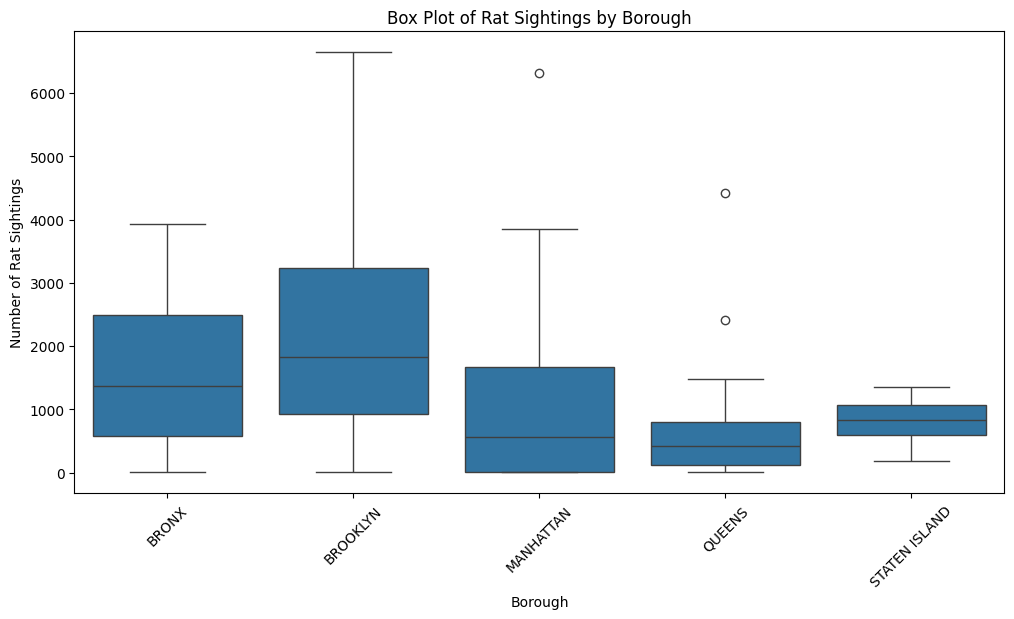

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='Borough', y='Sightings', data=sightings_per_zip)
plt.title('Box Plot of Rat Sightings by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Rat Sightings')
plt.xticks(rotation=45)
plt.show()


## **Follow-up** Post-hoc Test with Turkey's HSD Test



In [102]:
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

long_df = sightings_per_zip[['Borough', 'Sightings']].copy()
long_df = long_df.explode('Sightings').reset_index(drop=True)
long_df['Sightings'] = pd.to_numeric(long_df['Sightings'], errors='coerce')

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(long_df['Sightings'], long_df['Borough'], alpha=0.05)
print(tukey_results)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1      group2     meandiff  p-adj    lower      upper   reject
---------------------------------------------------------------------
    BRONX      BROOKLYN   635.8062 0.1739  -149.8804 1421.4929  False
    BRONX     MANHATTAN  -558.2111  0.216 -1283.2055  166.7833  False
    BRONX        QUEENS  -955.6202 0.0033 -1680.6146 -230.6257   True
    BRONX STATEN ISLAND  -726.2414 0.3827 -1843.2233  390.7405  False
 BROOKLYN     MANHATTAN -1194.0173    0.0 -1836.3486  -551.686   True
 BROOKLYN        QUEENS -1591.4264    0.0 -2233.7577 -949.0951   True
 BROOKLYN STATEN ISLAND -1362.0476 0.0048 -2427.2336 -296.8616   True
MANHATTAN        QUEENS  -397.4091 0.3045  -963.8921  169.0739  False
MANHATTAN STATEN ISLAND  -168.0303 0.9913  -1189.272  853.2114  False
   QUEENS STATEN ISLAND   229.3788 0.9721  -791.8629 1250.6205  False
---------------------------------------------------------------------


The results suggest that Brooklyn has significantly lower rat sightings compared to boroughs such as Manhattan, Queens, and Staten Island.

The results do not suggest significant differences in sightings between Bronx and Brooklyn, or between some other borough pairs.


One consideration to make is the size  of respective regions when interpreting these results. It would be important to incorporate this data to determine concentration of rat sightings when performing analysis within our final findings.

# Part 5: Final Test

# Analyzing Income: Cleaning & Visualizing Income in New York


We also cleaned a dataset on income differences in New York across Boroughs. Merging this dataset with our rat sightings dataset will be useful to provide insights into rat sighting relationships with income levels across New York.